# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the overall pollution estimations and AQI values.

## **Notebook Setup**

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [5]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## **Agents Estimations**

Prepare a dictionary containing all the models to use for each agent of each station.

TODO check if the model changed after new execution with standardized values

### **Hourly models**

#### XGBoost

In [6]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9
}

xgbr = ('XGB Regressor', xgb.XGBRegressor, xgbr_params, None, False)

#### LSTM

In [7]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True
}

lstm_train_params = {
    'epochs': 20,
    'batch_size': 64
}

lstm = ('LSTM-masked', build_lstm_model, lstm_params, lstm_train_params, True)

#### FFNN

In [8]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

FFNN2_BN = ('Feed Forward NN 2', build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

#### 1D Convolution

In [9]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64
}

conv = ('Conv1D', build_conv_model, conv_params, conv_train_params, True)

In [10]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

conv2 = ('Conv1D 2', build_conv_model, conv2_params, conv2_train_params, True)

In [11]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

conv3 = ('Conv1D 3', build_conv_model, conv3_params, conv3_train_params, True)

### **Daily Models**

#### FFNN

In [12]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32
}

FFNN_daily = ('Feed Forward NN', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [13]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

FFNN_daily_BN = ('Feed Forward NN BatchNorm', build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

In [14]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}

rfr2 = ('Random Forest Regressor 2', RandomForestRegressor, rfr2_params, None, False)

### **Training**

In [15]:
models = {
    'GIARDINI MARGHERITA':{
        'NO2': conv2, 
        'O3': conv3,
        'PM10': rfr2,
        'PM2.5': FFNN_daily 
    },
    'PORTA SAN FELICE':{
        'C6H6': conv, 
        'CO': xgbr, 
        'NO2': lstm,
        'PM10':FFNN_daily_BN,  
        'PM2.5':FFNN_daily_BN 
    },
    'VIA CHIARINI':{
        'NO2': FFNN2_BN, 
        'O3': conv2, 
        'PM10':rfr2  
    }
}

In [16]:
agents_predictions = train_agents(
    models, train_sets, test_sets,
    # model_out_folder='./models'
)

Predicting NO2 in GIARDINI MARGHERITA using Conv1D 2...
Predicting O3 in GIARDINI MARGHERITA using Conv1D 3...
Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor 2...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
Predicting C6H6 in PORTA SAN FELICE using Conv1D...
Predicting CO in PORTA SAN FELICE using XGB Regressor...
Predicting NO2 in PORTA SAN FELICE using LSTM-masked...
Predicting PM10 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
Predicting NO2 in VIA CHIARINI using Feed Forward NN 2...
Predicting O3 in VIA CHIARINI using Conv1D 2...
Predicting PM10 in VIA CHIARINI using Random Forest Regressor 2...


In [17]:
metrics_predictions = training_results_to_dataframe(agents_predictions, multiple_models=False)
metrics_predictions

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,NO2,0.547487,0.574770,0.368232,0.299742
1,GIARDINI MARGHERITA,O3,0.342967,0.867876,0.256808,0.117626
2,GIARDINI MARGHERITA,PM10,0.731112,0.407816,0.515383,0.534525
3,GIARDINI MARGHERITA,PM2.5,0.708156,0.502087,0.495409,0.501486
4,PORTA SAN FELICE,C6H6,0.557776,0.662259,0.353490,0.311115
5,PORTA SAN FELICE,CO,0.666063,0.575716,0.511849,0.443640
6,PORTA SAN FELICE,NO2,0.986571,-0.801634,0.821839,0.973323
7,PORTA SAN FELICE,PM10,0.748872,0.444876,0.500015,0.560809
8,PORTA SAN FELICE,PM2.5,0.634864,0.608765,0.458414,0.403052
9,VIA CHIARINI,NO2,0.602679,0.411135,0.388520,0.363222


## **AQI calculation**

The steps to compute the Air Quality Index are the same illustrated in the [pollution notebook](./1-pollution_preprocessing.ipynb):


- we go back to the original distribution,

In [18]:
agents_predictions_original_dist = agents_predictions.copy()
test_sets_original_dist = test_sets.copy()

In [19]:
for station in stations:
    for agent in agents_predictions_original_dist[station]:
        test_sets_original_dist[station][agent]['y'] = (test_sets_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_original_dist[station][agent]['predictions'] = (agents_predictions_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']


- then we compute the AQI of each agent,
- and then we take the maximums for each time step

In [20]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [21]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

- We also compute the difference between the true AQIs and the predicted values, for better comparison.

In [22]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## **AQI Comparison**

In [23]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}

### **Hourly AQI**

Station GIARDINI MARGHERITA AQI:


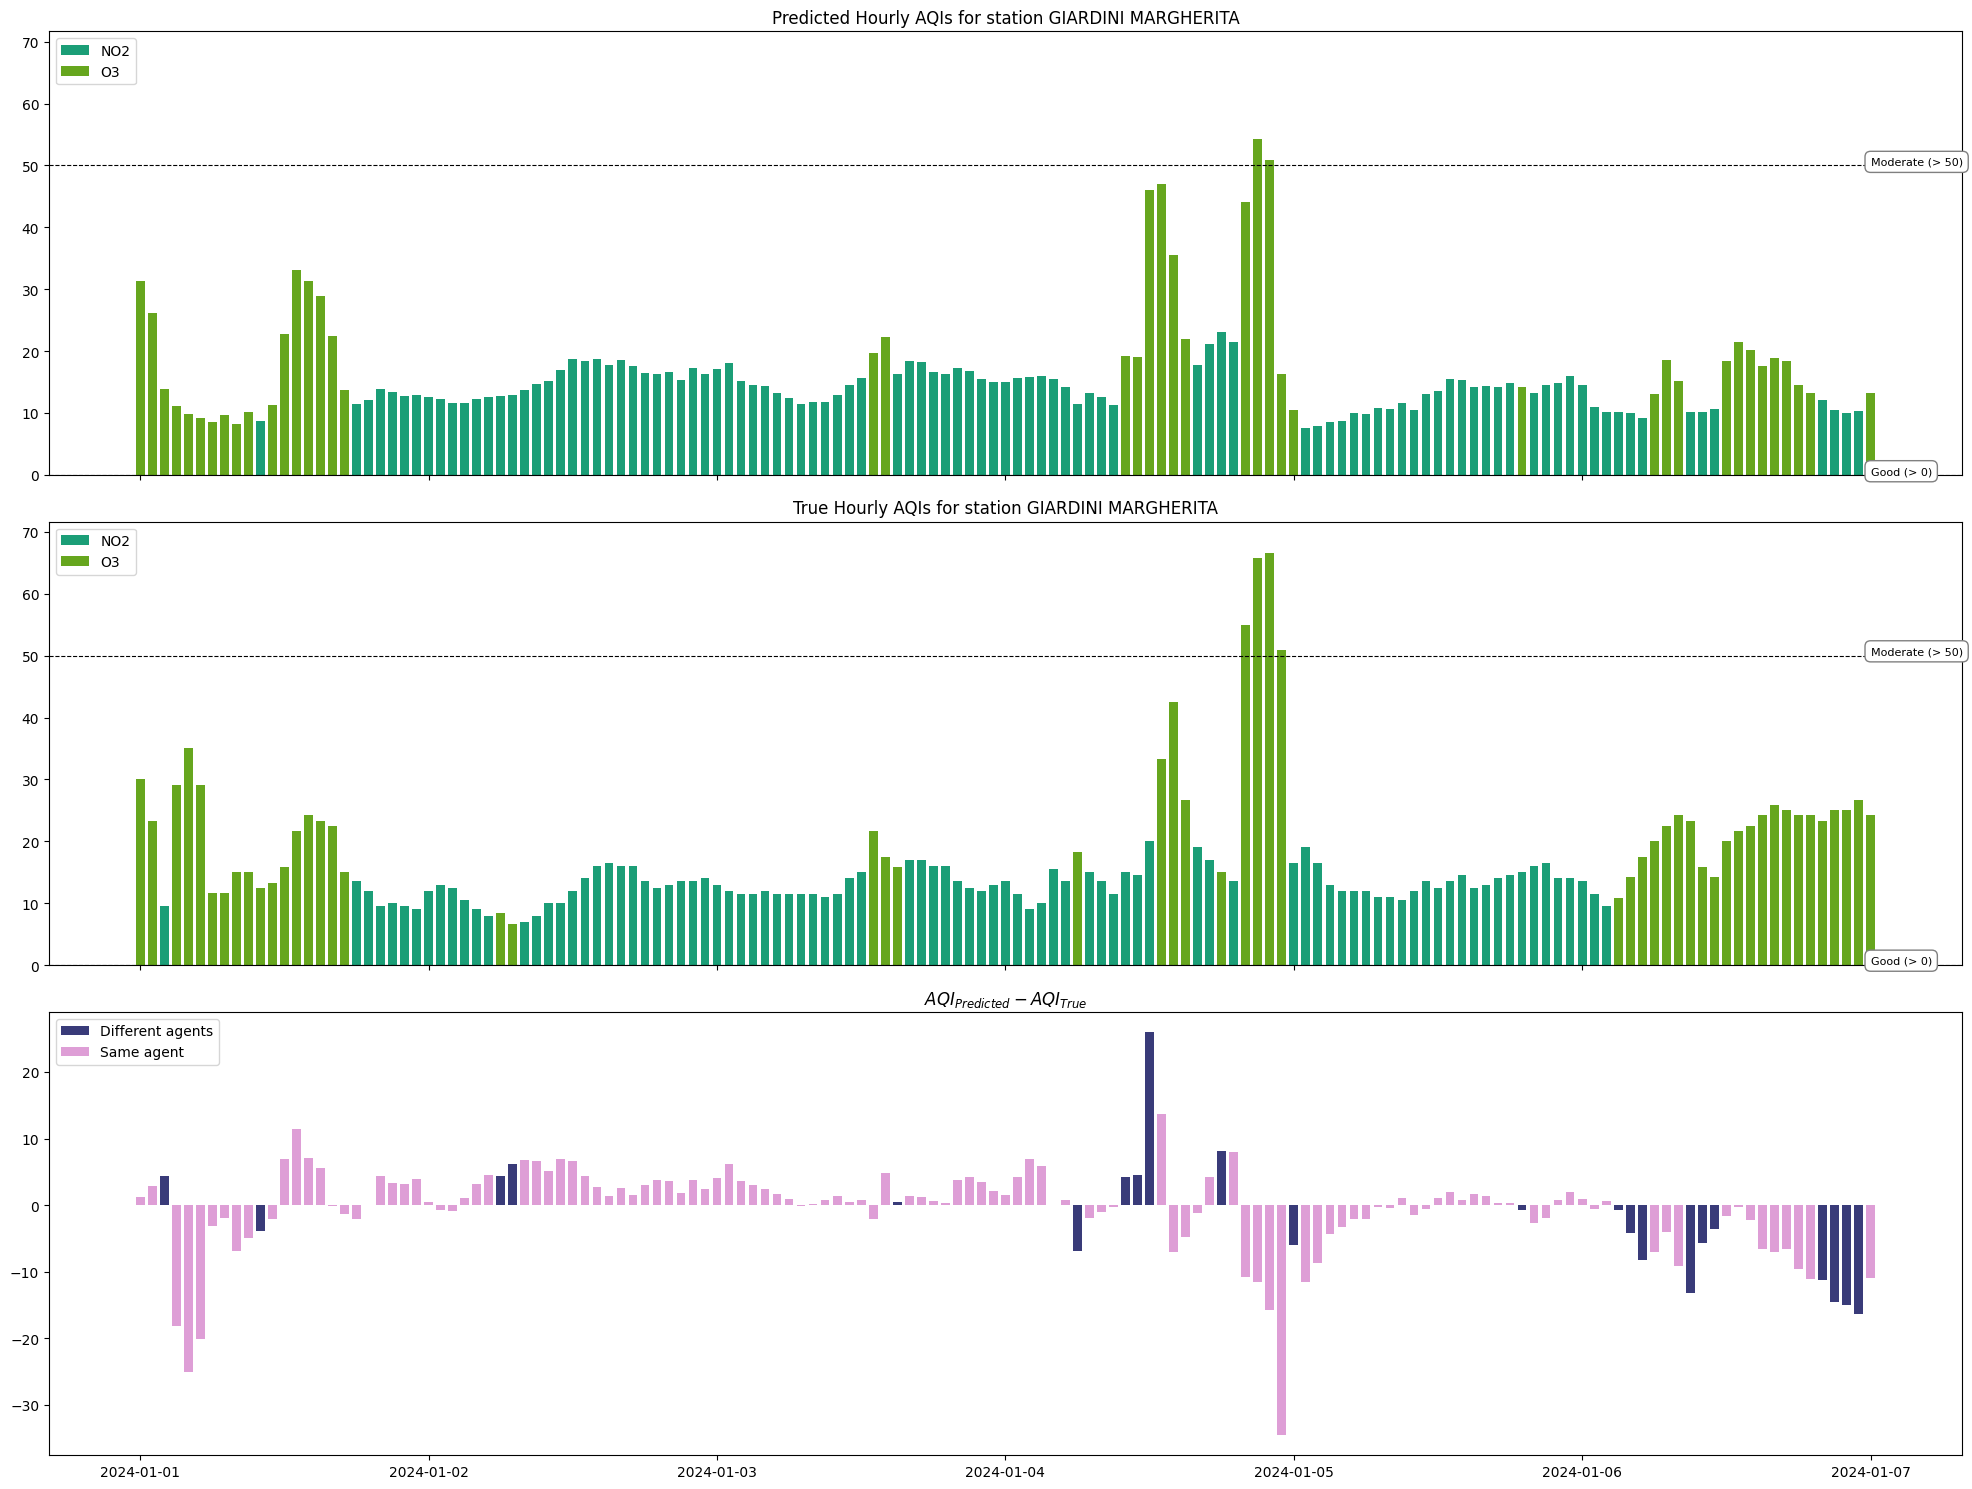

Station PORTA SAN FELICE AQI:


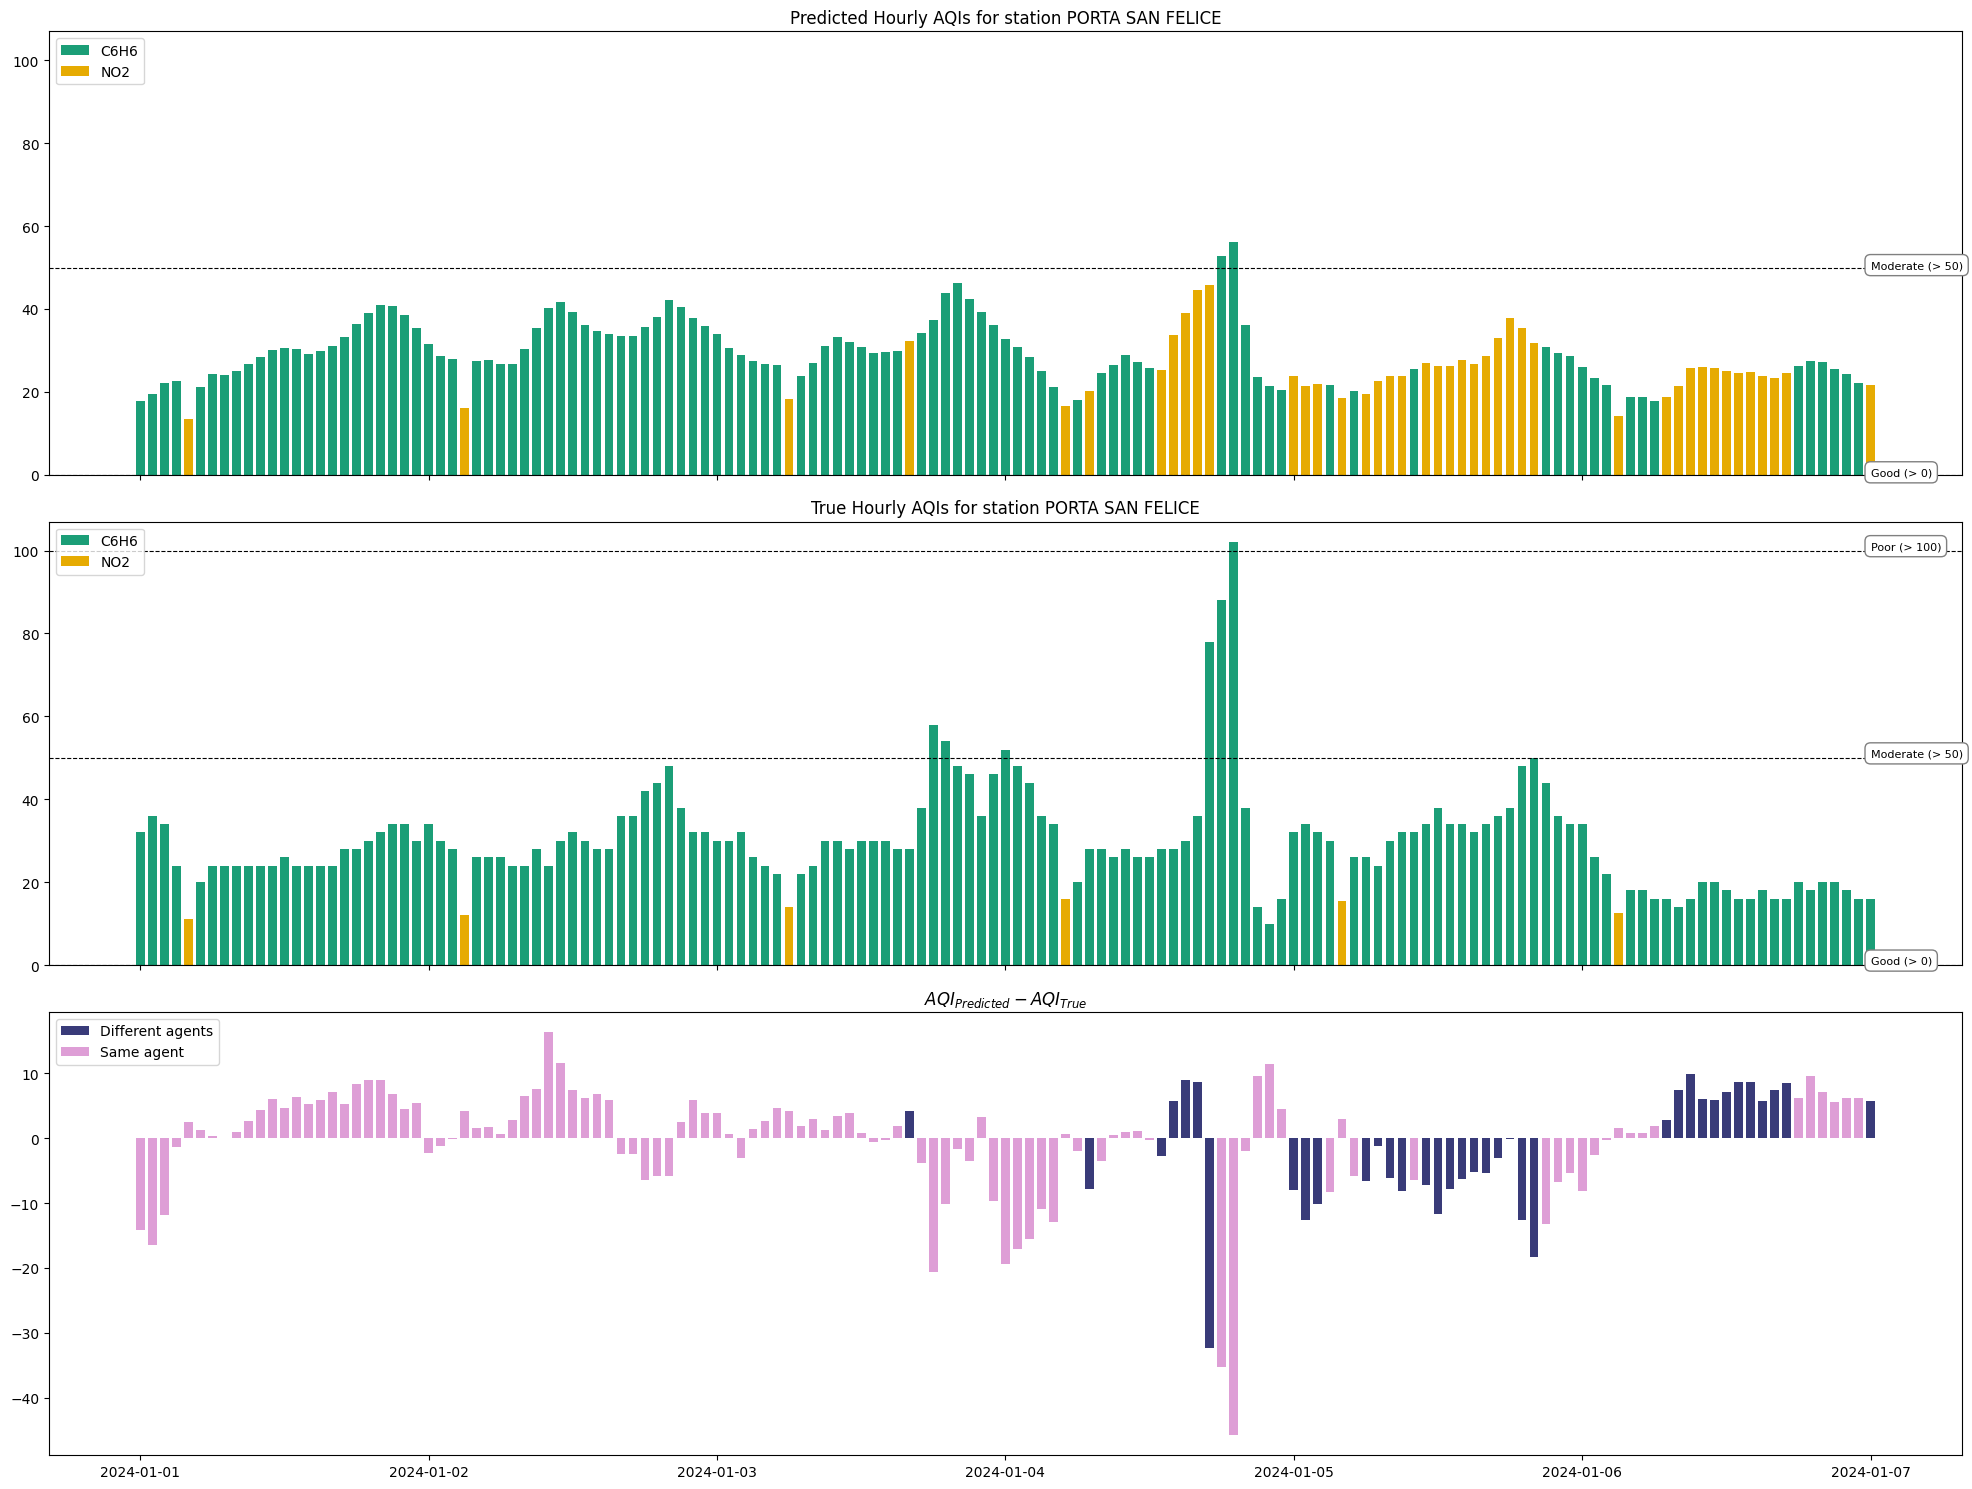

Station VIA CHIARINI AQI:


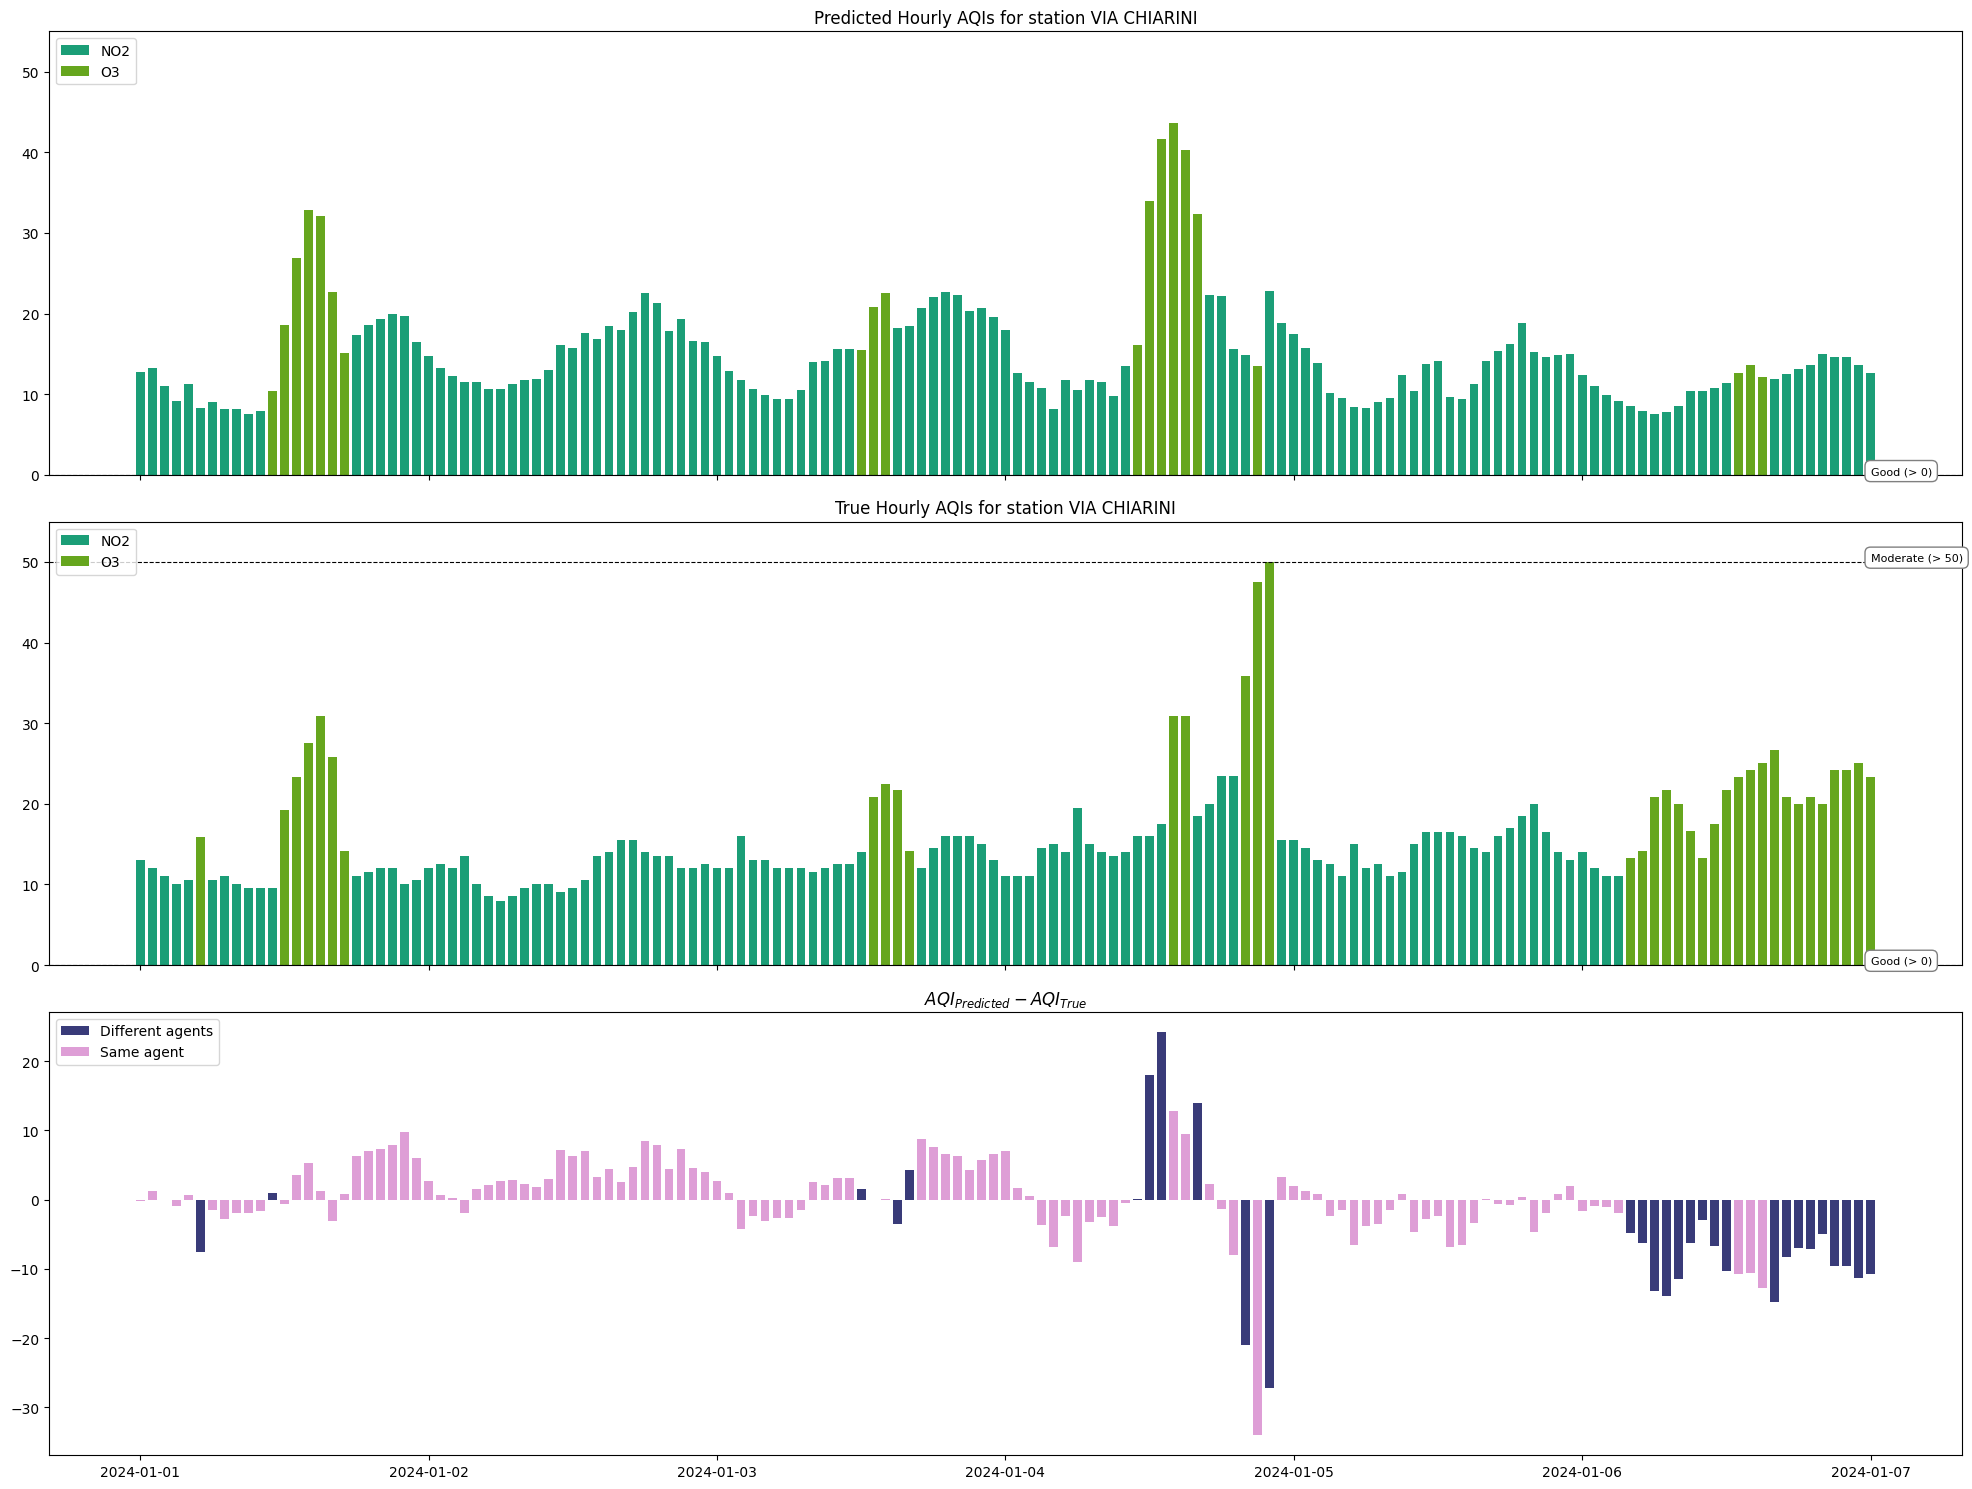

In [24]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA


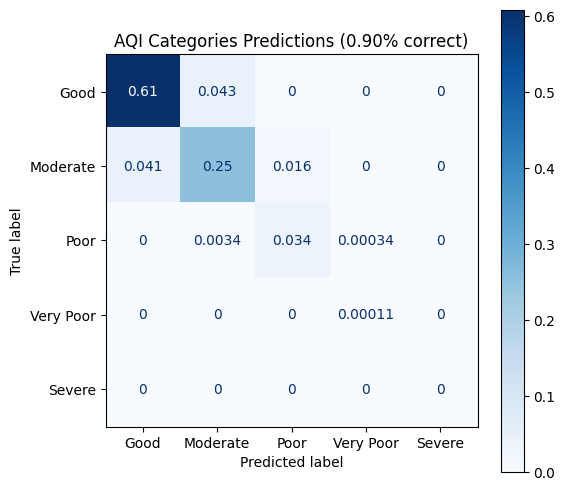

---------------------------------------------
> Absolute Mean AQI Difference: 7.64
> Positive Average AQI Difference: 7.34
> Negative Average AQI Difference: -7.95
> Percentage of Positive Differences: 51.30%
> Percentage of Negative Differences: 48.49%
> Percentage of Agent Values:
   - Same agent: 88.62
   - Different agents: 11.38
Station PORTA SAN FELICE


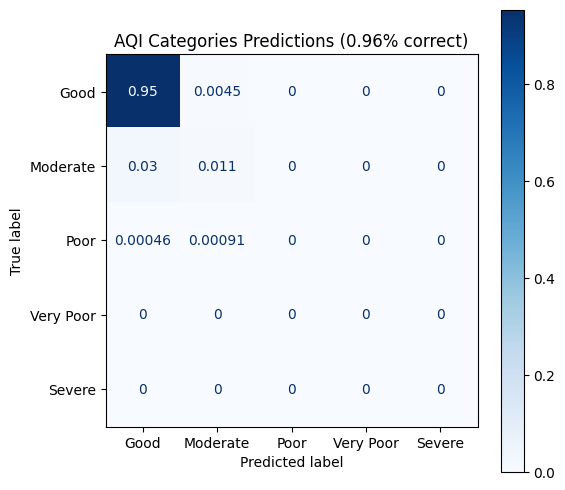

---------------------------------------------
> Absolute Mean AQI Difference: 6.32
> Positive Average AQI Difference: 5.92
> Negative Average AQI Difference: -6.92
> Percentage of Positive Differences: 60.02%
> Percentage of Negative Differences: 39.79%
> Percentage of Agent Values:
   - Same agent: 59.35
   - Different agents: 40.65
Station VIA CHIARINI


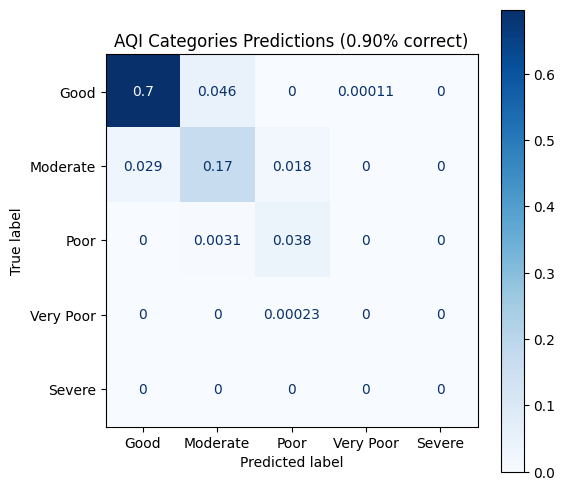

---------------------------------------------
> Absolute Mean AQI Difference: 7.86
> Positive Average AQI Difference: 8.58
> Negative Average AQI Difference: -6.74
> Percentage of Positive Differences: 60.78%
> Percentage of Negative Differences: 38.91%
> Percentage of Agent Values:
   - Same agent: 86.78
   - Different agents: 13.22


In [25]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

### **Daily AQI**

Station GIARDINI MARGHERITA AQI:


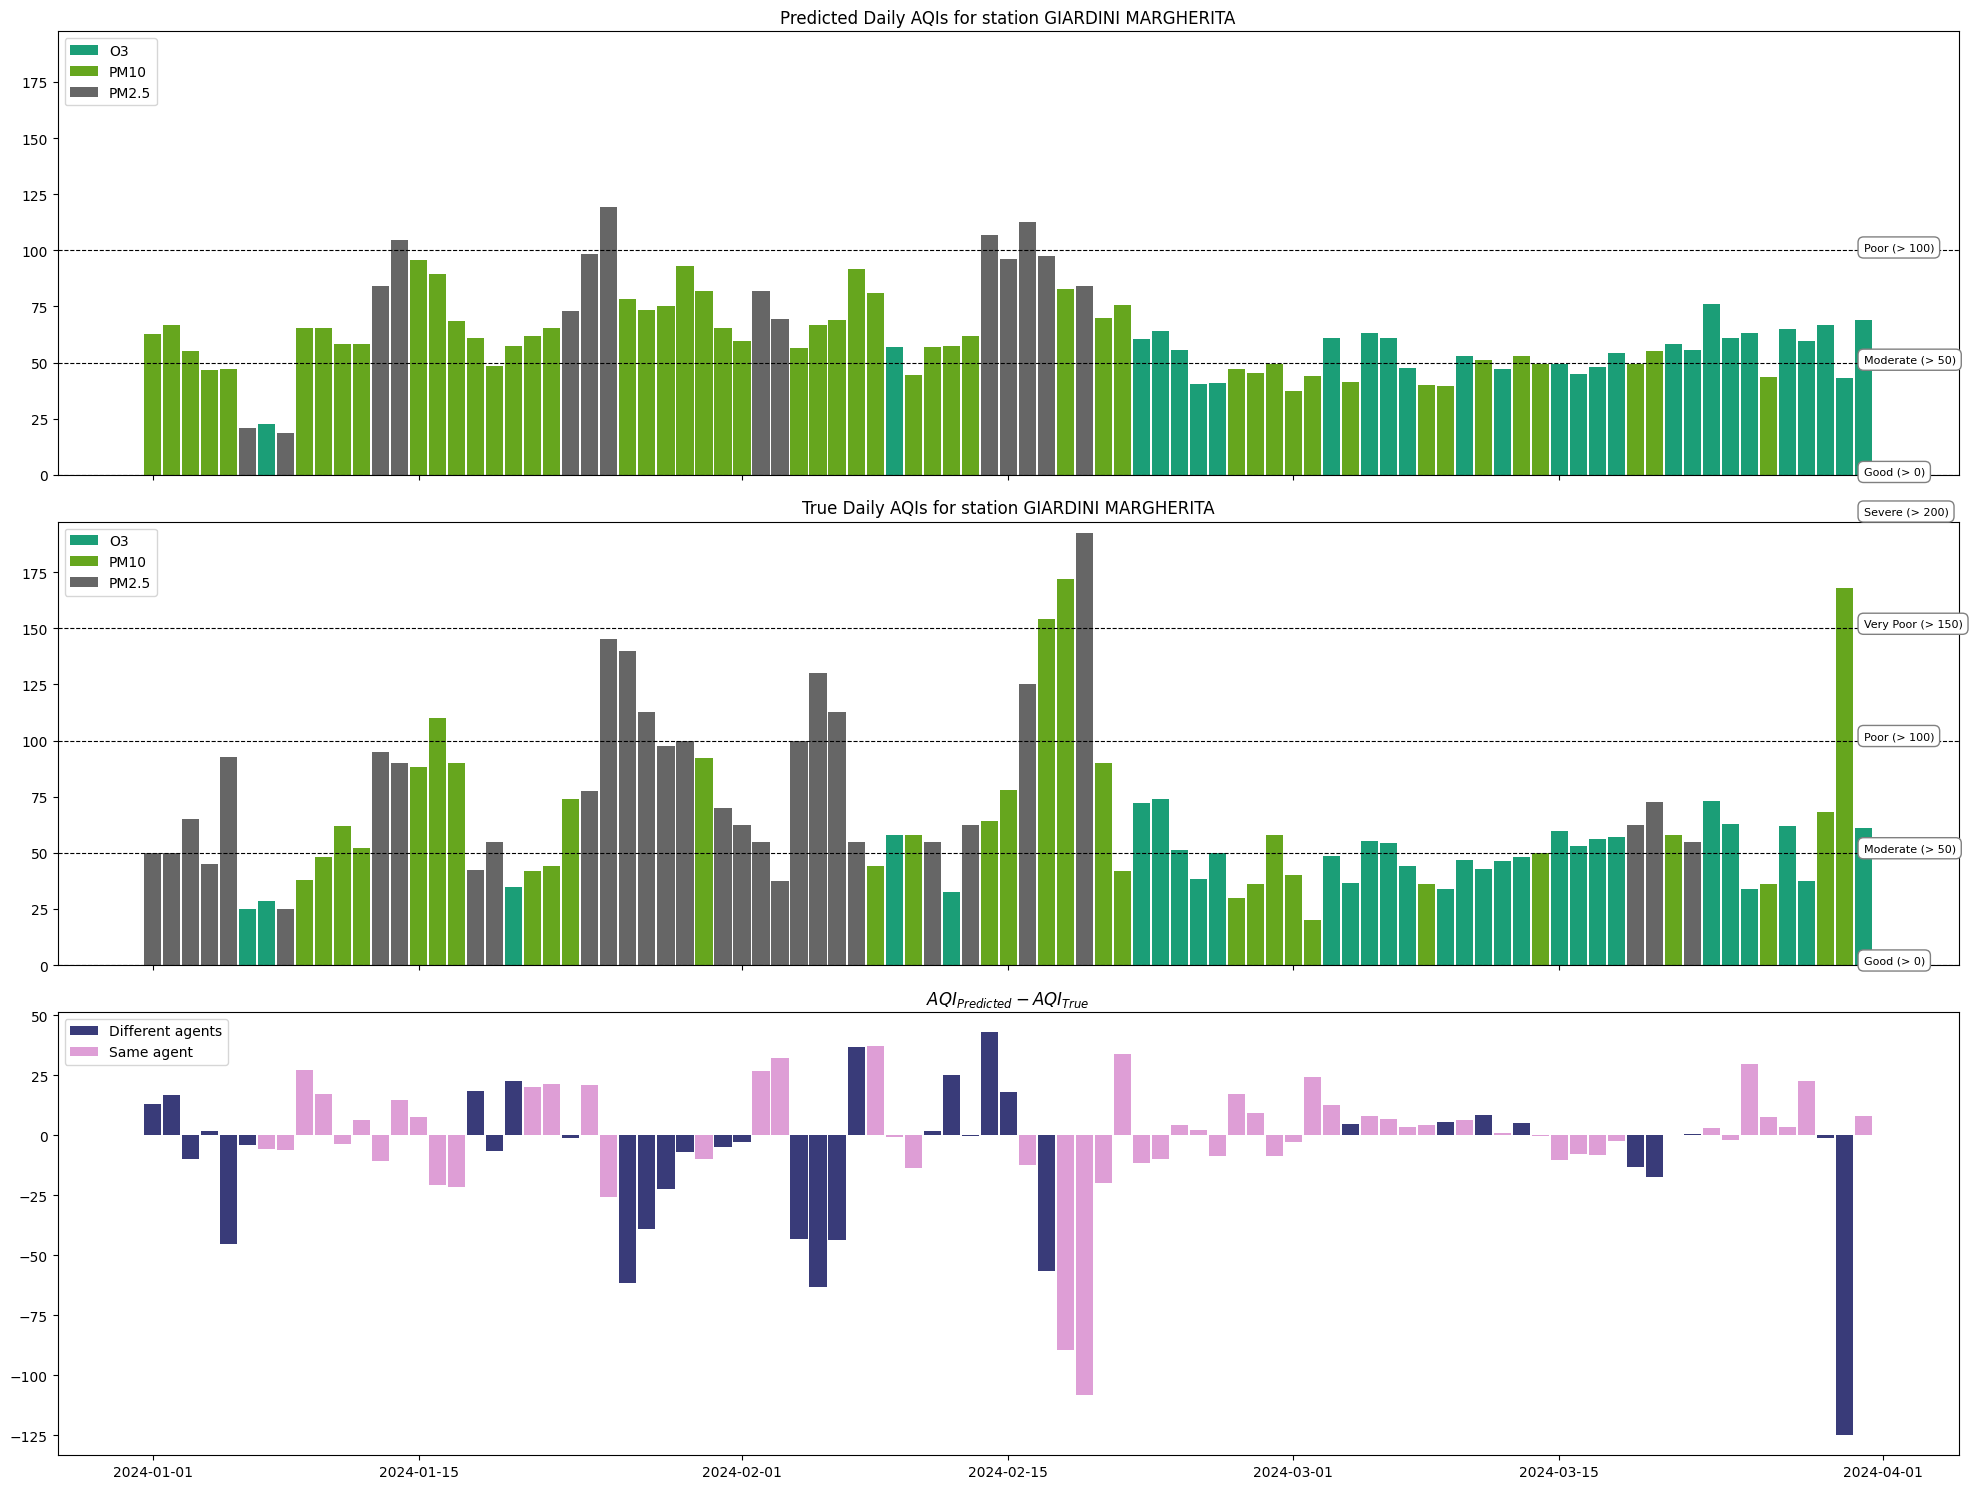

Station PORTA SAN FELICE AQI:


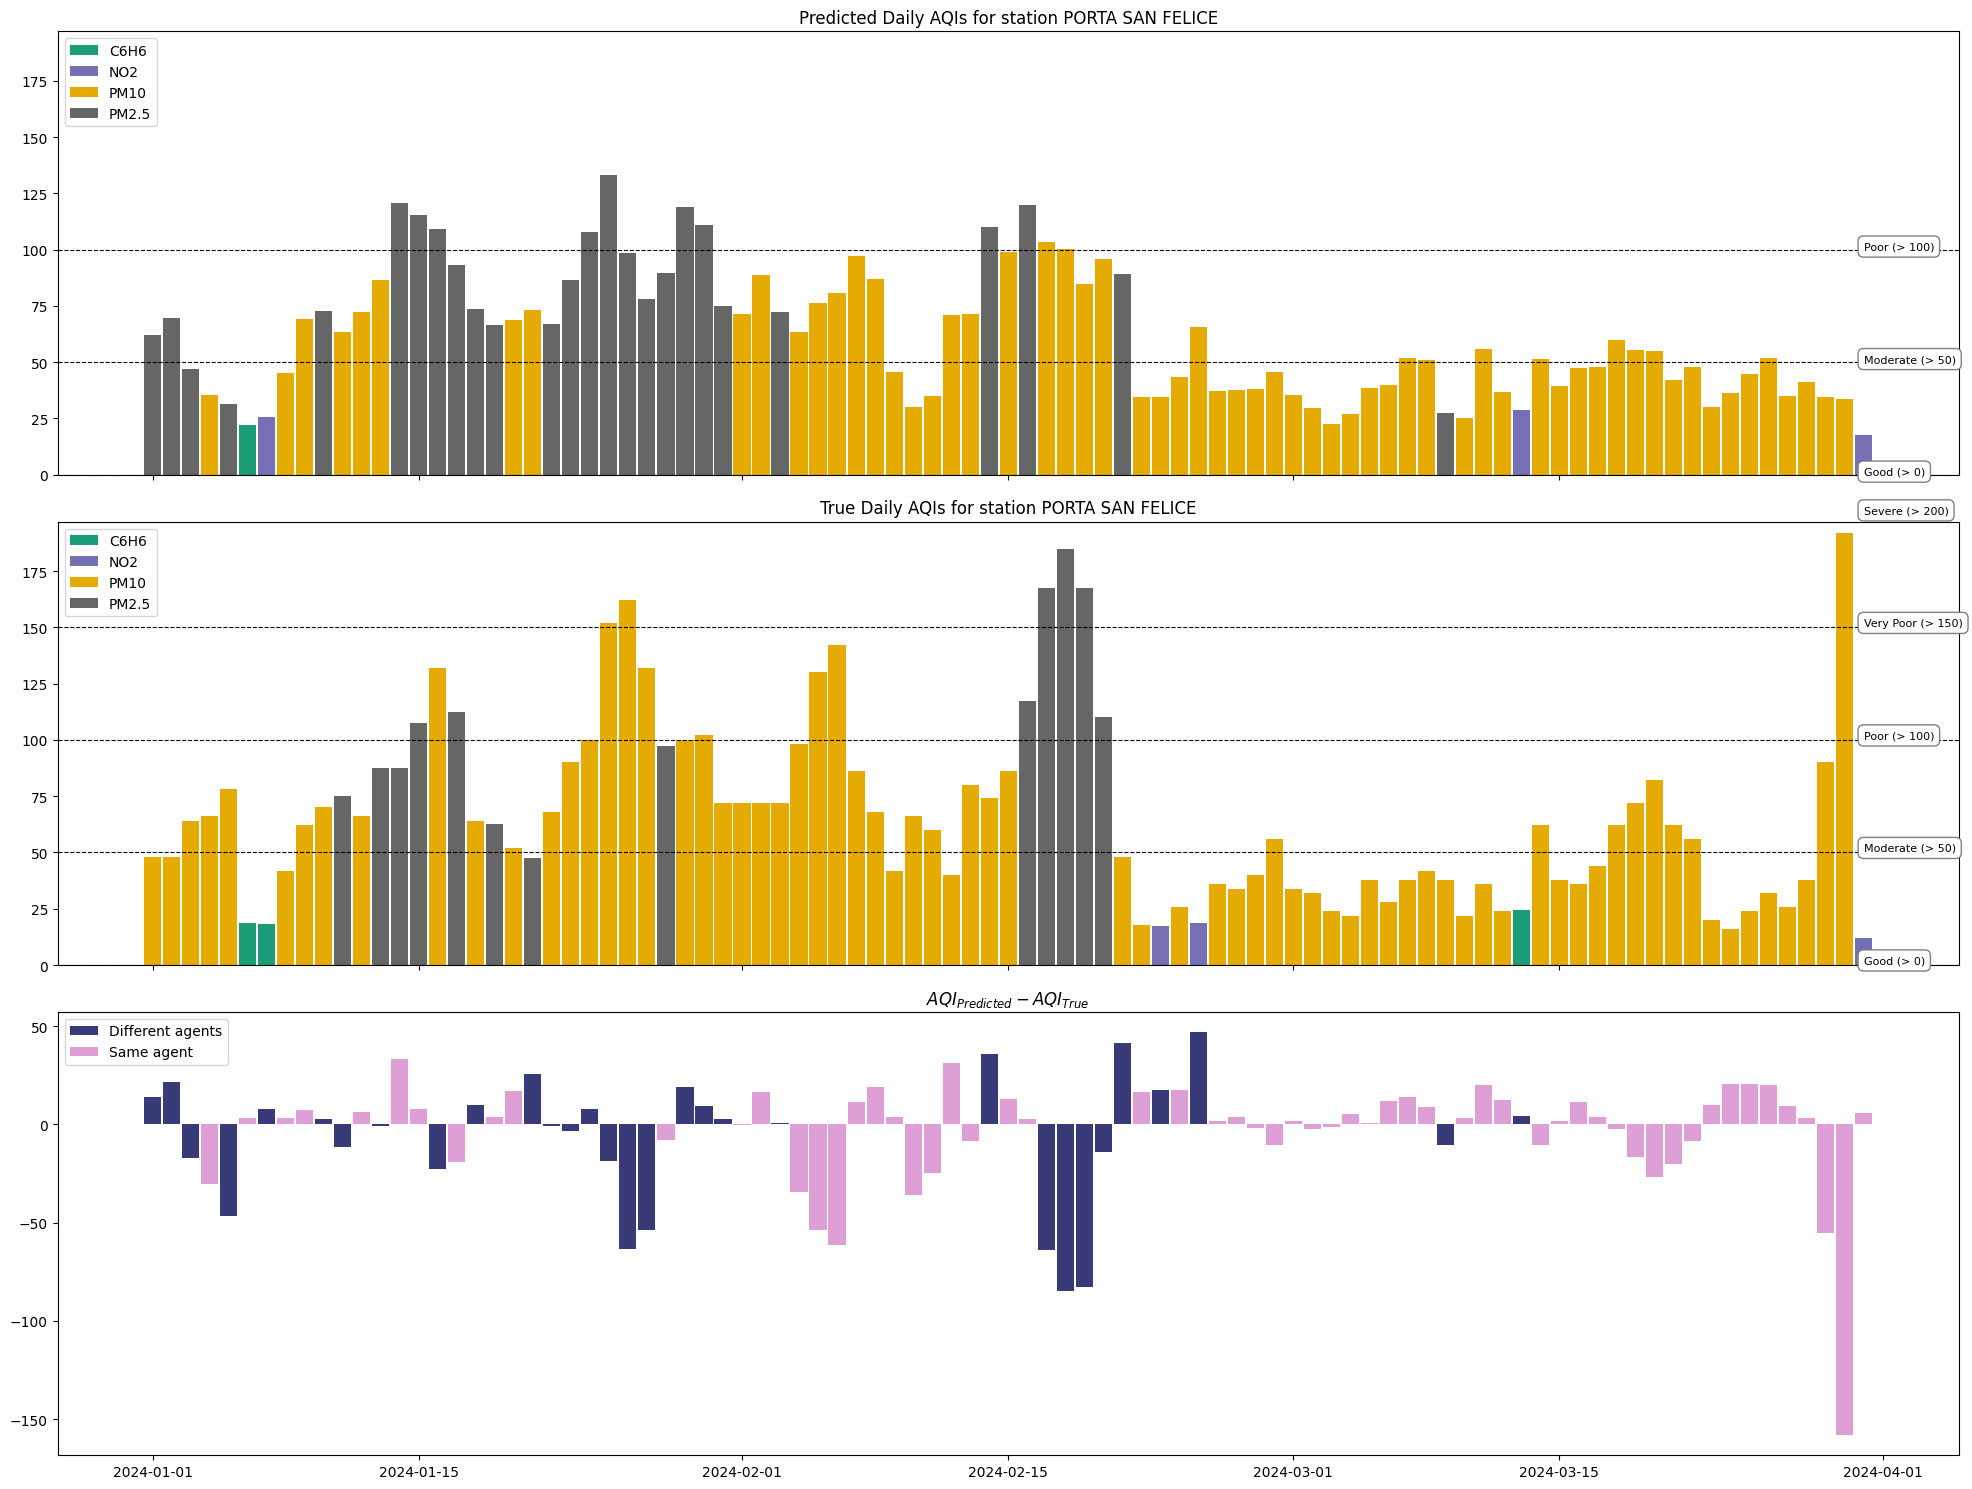

Station VIA CHIARINI AQI:


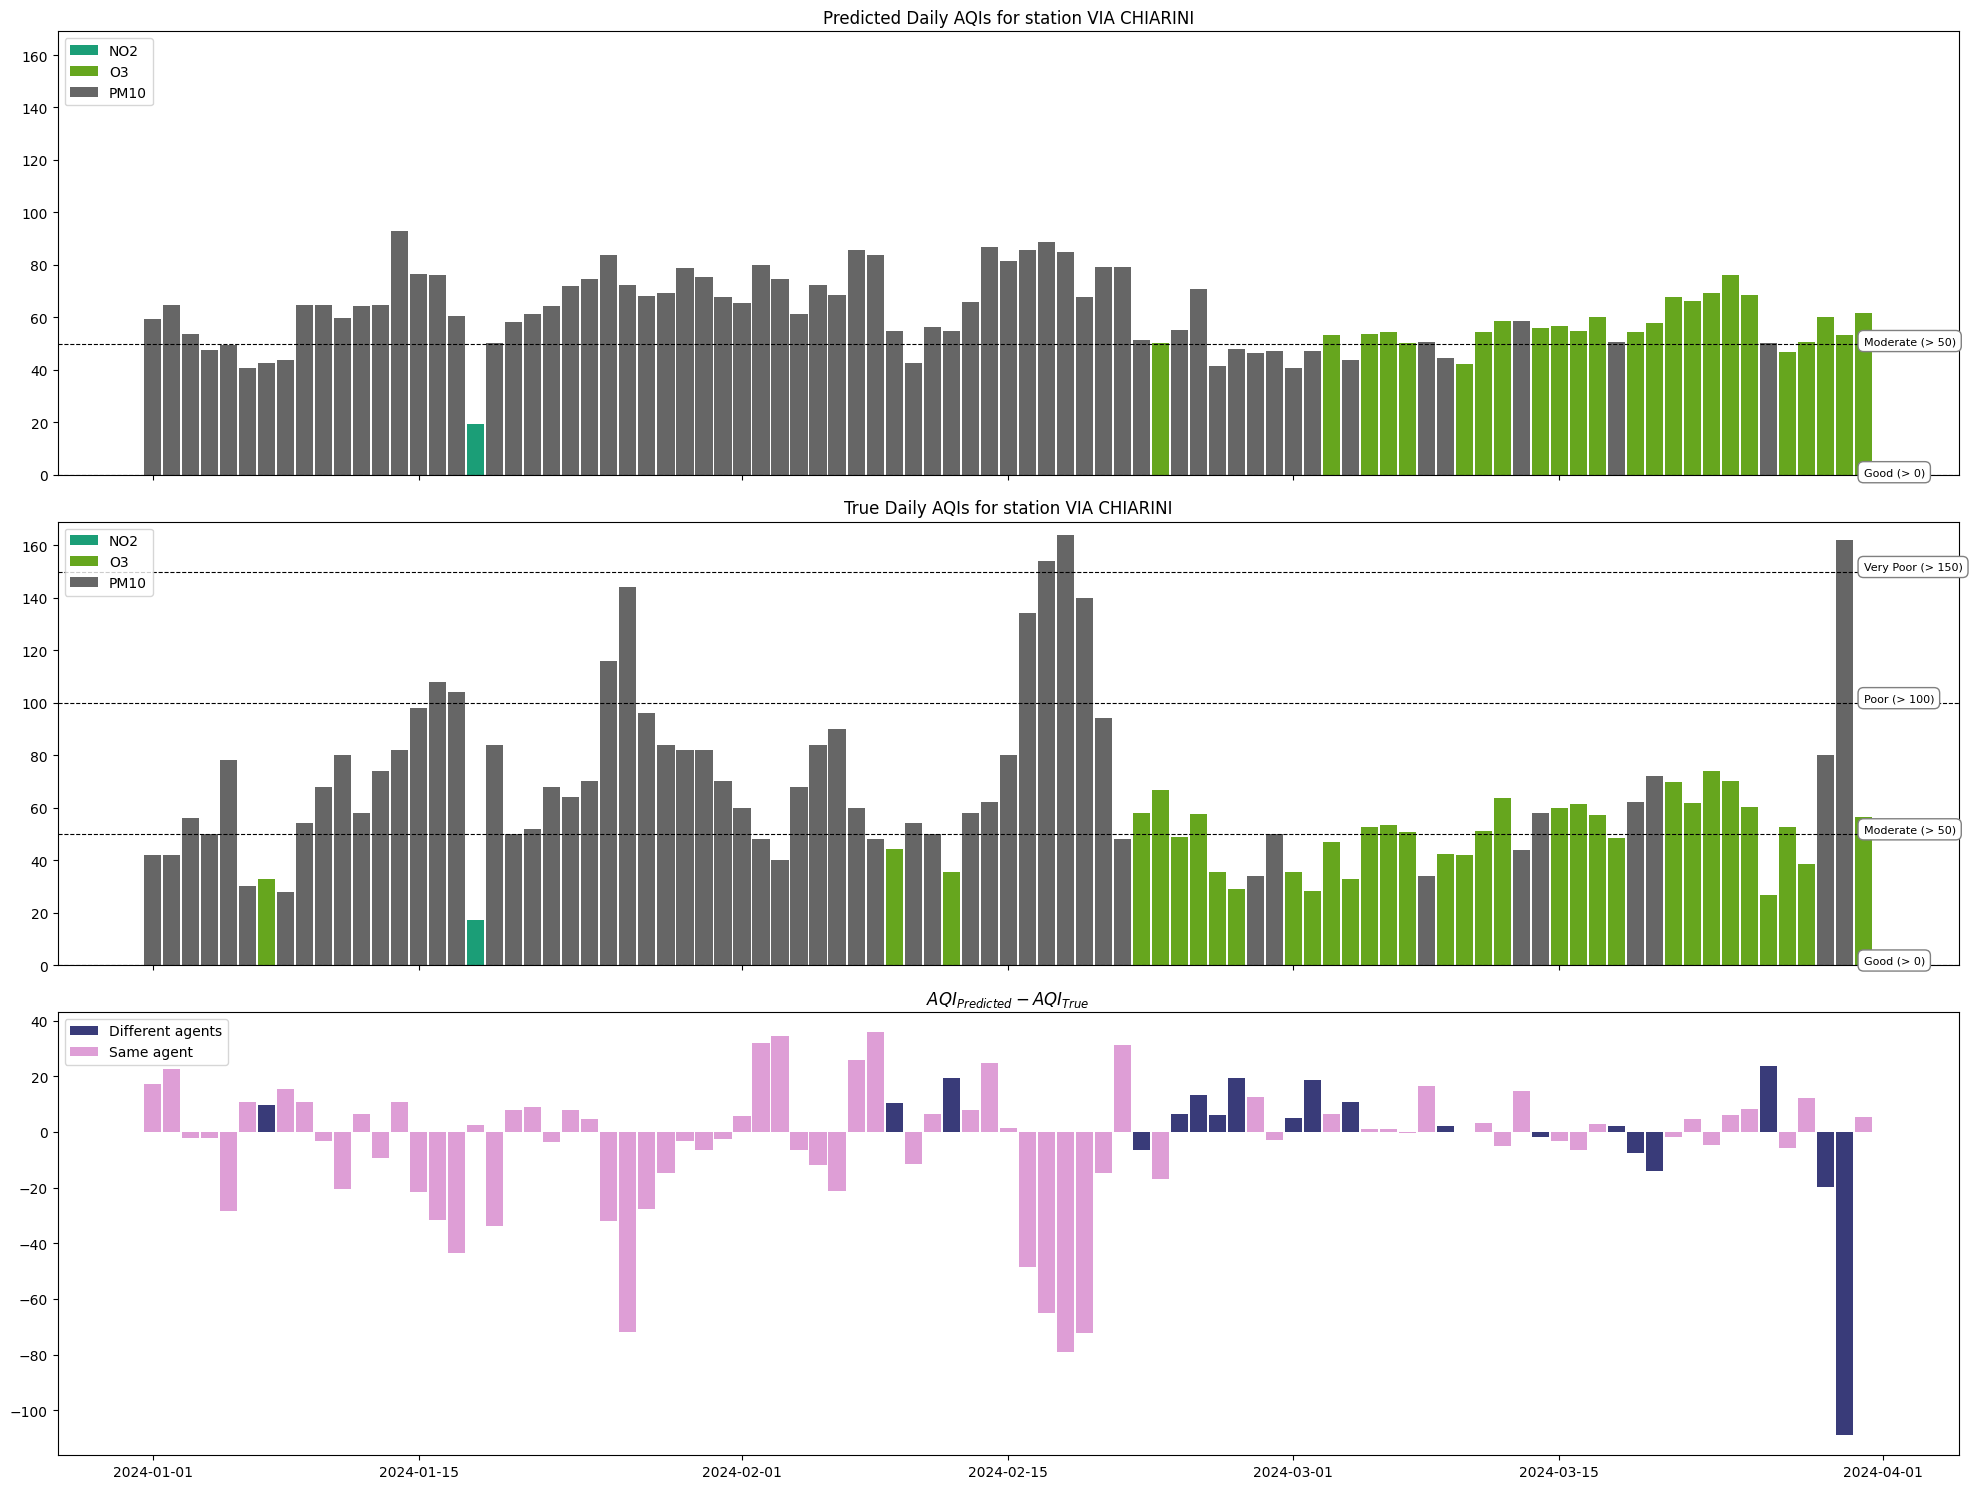

In [26]:
start=datetime(2024,1,1)
end=datetime(2024,3,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=categories,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA


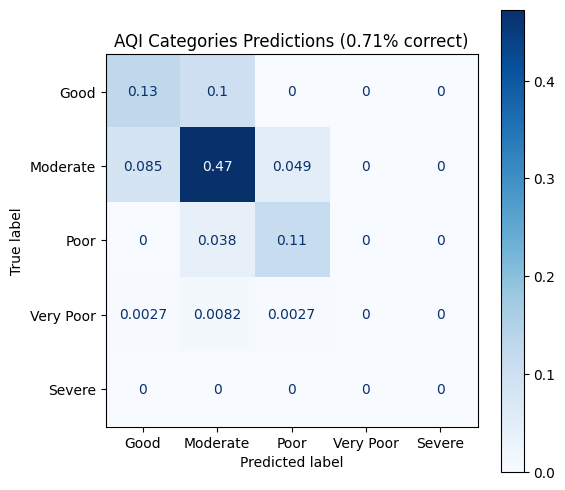

---------------------------------------------
> Absolute Mean AQI Difference: 12.95
> Positive Average AQI Difference: 11.62
> Negative Average AQI Difference: -14.59
> Percentage of Positive Differences: 55.19%
> Percentage of Negative Differences: 44.81%
> Percentage of Agent Values:
   - Same agent: 77.6
   - Different agents: 22.4
Station PORTA SAN FELICE


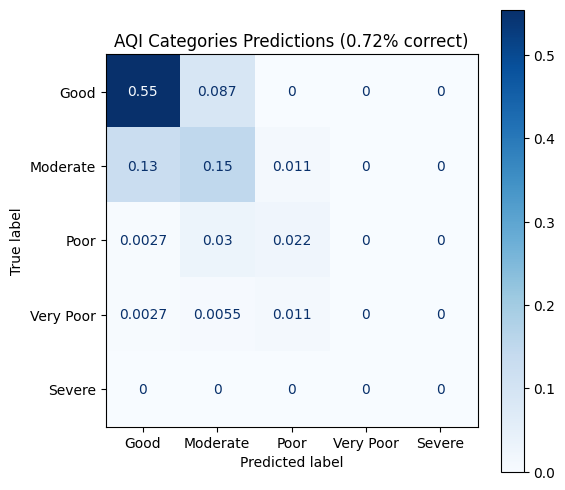

---------------------------------------------
> Absolute Mean AQI Difference: 14.87
> Positive Average AQI Difference: 11.48
> Negative Average AQI Difference: -19.39
> Percentage of Positive Differences: 57.10%
> Percentage of Negative Differences: 42.90%
> Percentage of Agent Values:
   - Same agent: 79.78
   - Different agents: 20.22
Station VIA CHIARINI


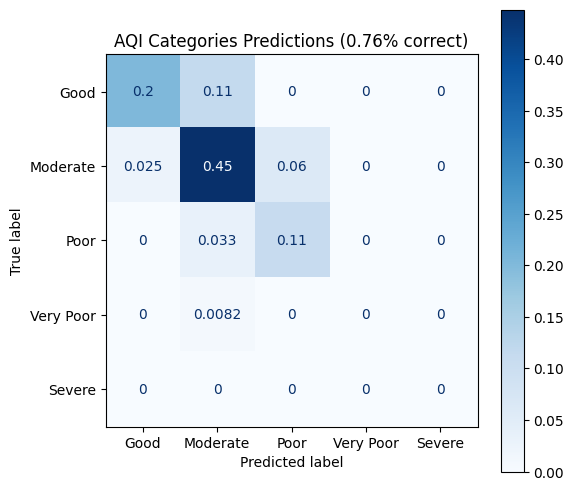

---------------------------------------------
> Absolute Mean AQI Difference: 12.40
> Positive Average AQI Difference: 11.68
> Negative Average AQI Difference: -13.94
> Percentage of Positive Differences: 68.03%
> Percentage of Negative Differences: 31.97%
> Percentage of Agent Values:
   - Same agent: 85.25
   - Different agents: 14.75


In [27]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')